# Network properties

In this notebook we run a basic analysis of network properties as well as visualizations, including a spring layout plots of the contact network, community dectection, and degree distribution.

In [1]:
import os
from os import path
import random
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib.animation import FuncAnimation

import seaborn as sns
import networkx as nx

# Utility code is saved in separate python files to shorten the notebook
from utils.plotting import plot_hist_values, color_graph_by_attribute

In [22]:
# Dataset ID
dataset_id = 34

In [23]:
data_folder = path.join('./data', str(dataset_id))
output_folder = path.join('./output', str(dataset_id))
if not path.exists(output_folder):
    os.makedirs(output_folder)

In [24]:
# Set a random seed for reproducibility
random_seed = 32
random.seed(random_seed)

with open(path.join(data_folder, 'full-network.pickle'), 'rb') as f:
    G0 = pickle.load(f)

with open(path.join(data_folder, 'network-largest_conn_comp.pickle'), 'rb') as f:
    G = pickle.load(f)

## Plotting the contat network

The first step to understand the structure of the network is to visualize it. Since this is a relatively large network (almost 500 nodes) a force-directed [spring layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html) can be helpful to get a plot that's easier to interpret. We do this for the full network, and then for the largest connected component subnetwor.

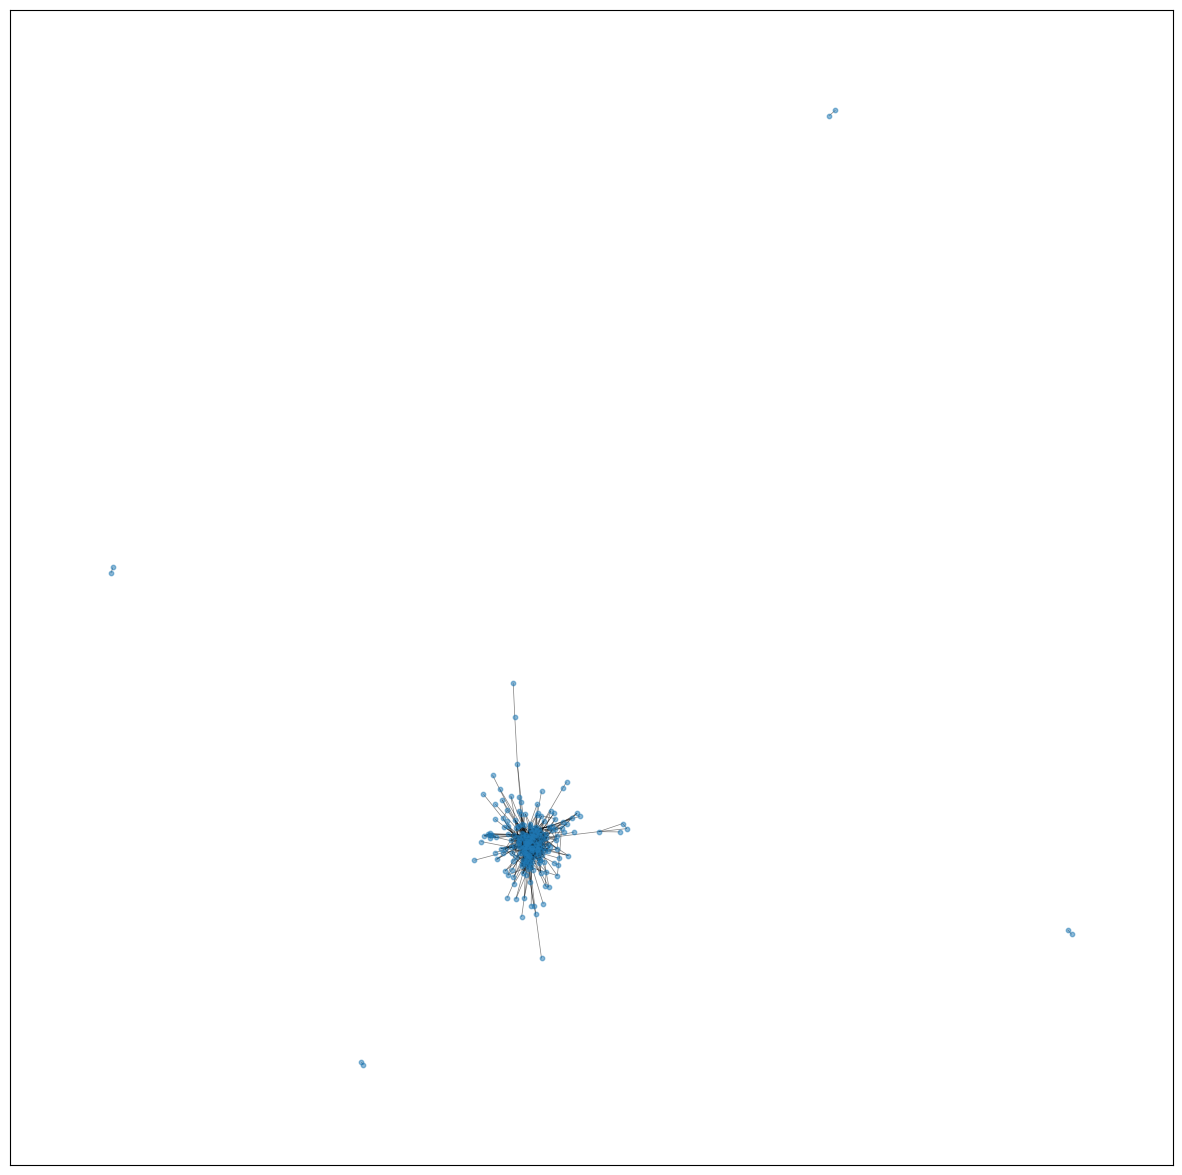

In [25]:
pos0 = nx.spring_layout(G0, seed=random_seed)
plt.figure(figsize=(15, 15))
nx.draw_networkx(G0, pos0, with_labels=False, node_size=10, width=0.5, alpha=0.5)
plt.show()

In [26]:
# Calculating the node positions for the largest connected component
Gpos = nx.spring_layout(G, seed=random_seed)

with open(path.join(data_folder, 'network-node-positions.pickle'), 'wb') as f:
    pickle.dump(Gpos, f)

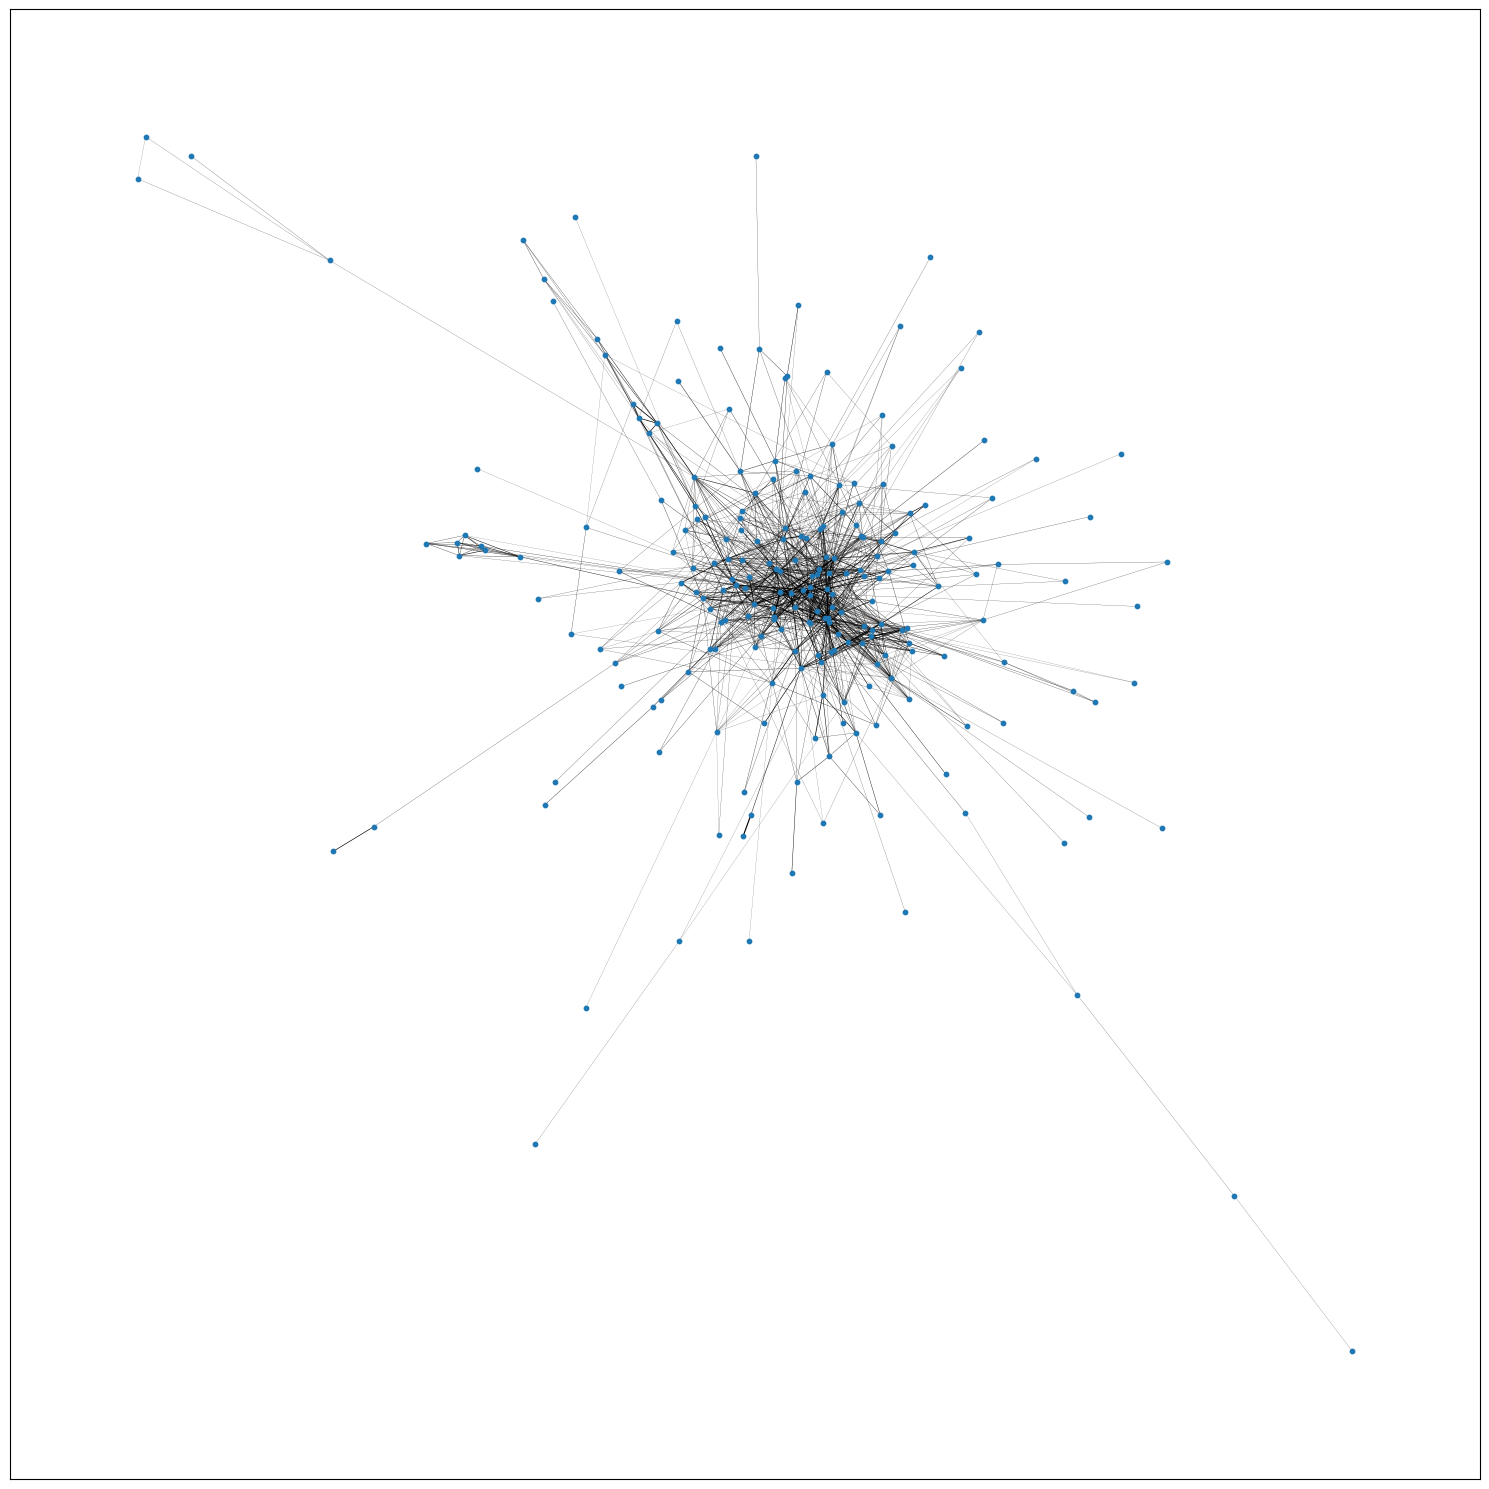

In [27]:
plt.figure(figsize=(15, 15))

weights = list(nx.get_edge_attributes(G, 'weight').values())
wmin = np.min(weights)/2
wmax = np.max(weights)
edge_weights = [pow((w - wmin)/(wmax-wmin), 0.35) for w in weights] 

nx.draw_networkx(G, Gpos, with_labels=False, node_size=10, width=edge_weights, alpha=1)
plt.tight_layout()
plt.savefig(path.join(output_folder, 'network.png'))
plt.show()

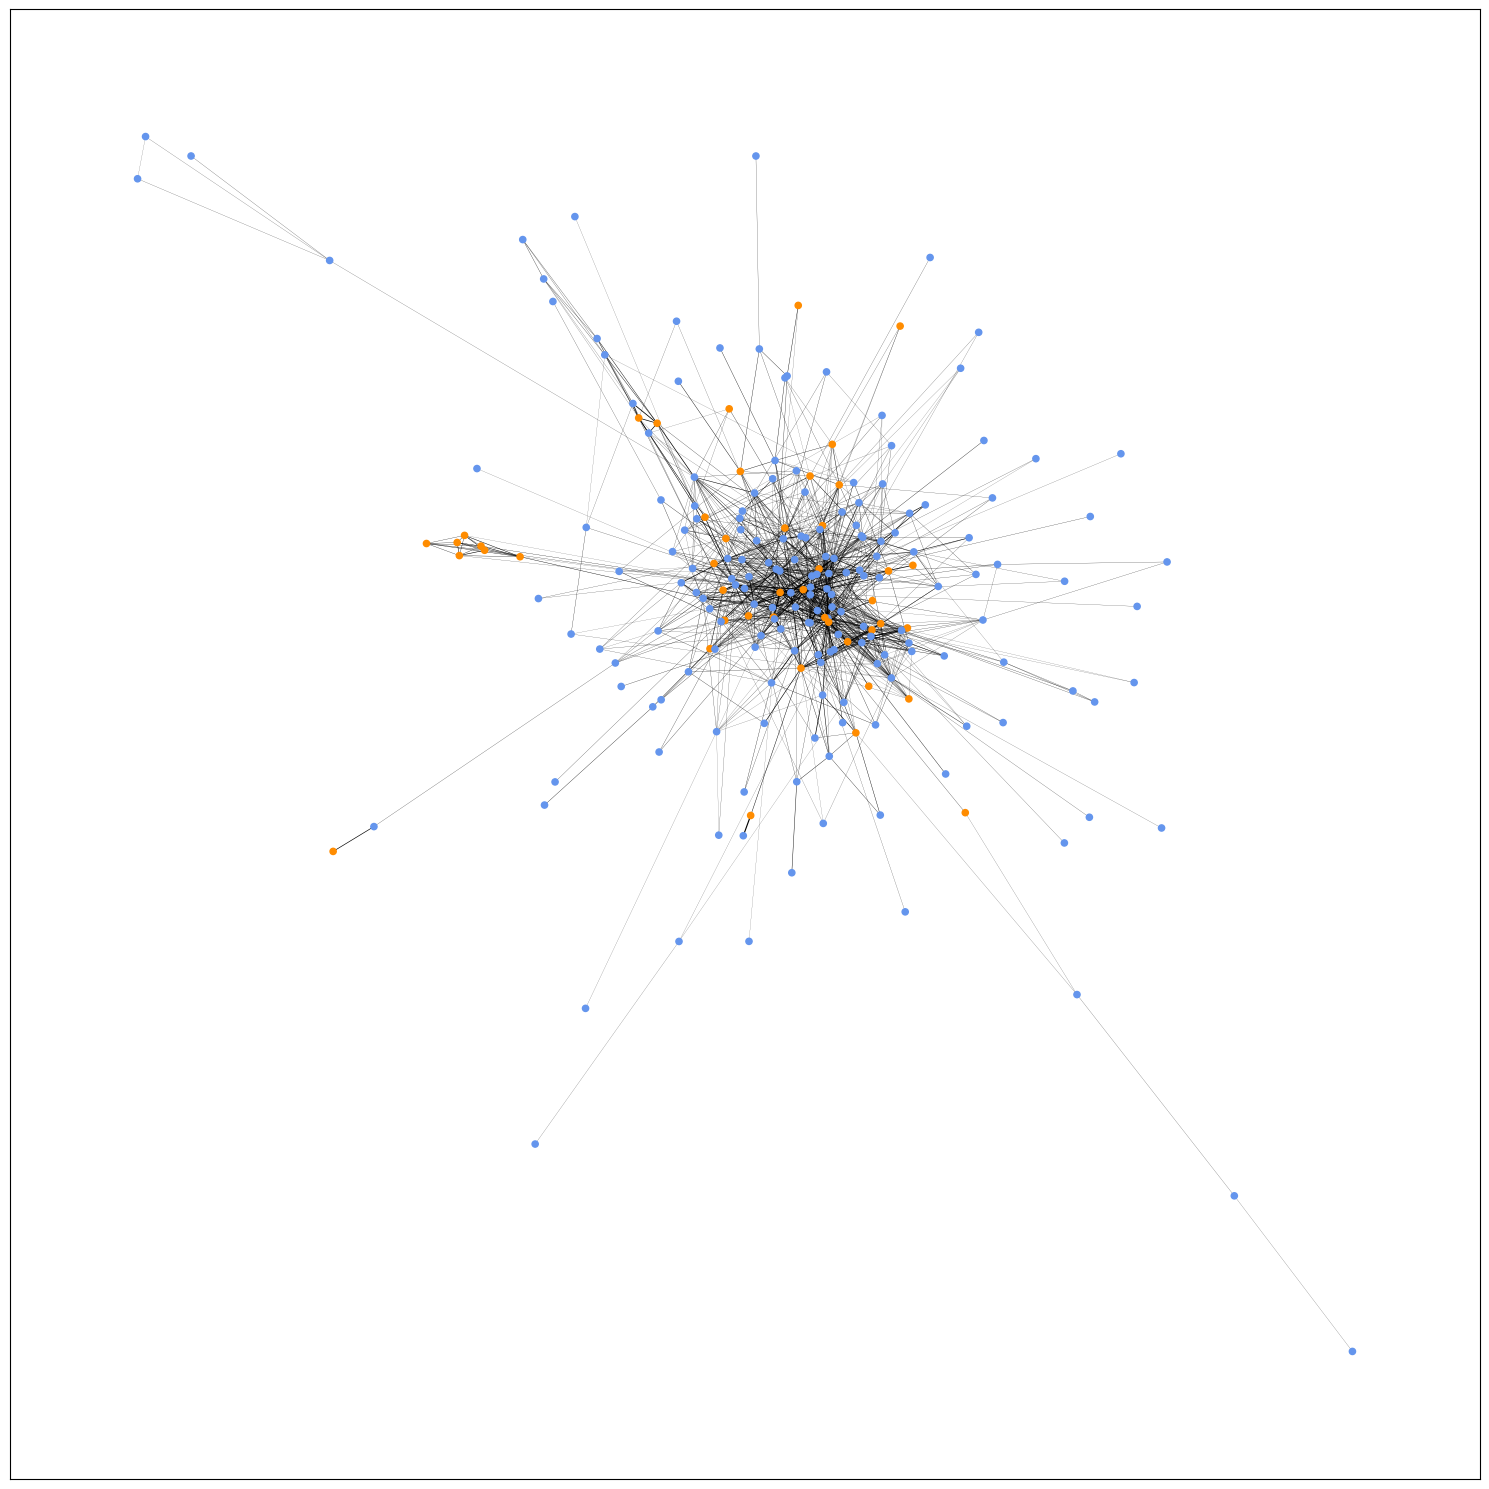

In [28]:
# Plot network colored by infected/not-infected state

# Binary color map for healthy/infected final status:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
health_color = {0: clr.to_hex("cornflowerblue"),  # Susceptible
                1: clr.to_hex("darkorange"),      # Infected (index case)
                2: clr.to_hex("darkorange"),      # Infected (from someone else)
                3: clr.to_hex("darkorange"),      # Dead 
                4: clr.to_hex("darkorange"),      # Recovered 
                5: clr.to_hex("darkorange")       # Vaccinated 
               } 

colors = [health_color[G.nodes[node]["final_health_state"]] for node in G.nodes()]

plt.figure(figsize=(15, 15))
nx.draw_networkx(G, Gpos, node_color=colors, with_labels=False, node_size=20, width=edge_weights, alpha=1)
#nx.draw(G, Gpos, ax=ax, node_color=colors, with_labels=False, node_size=7, width=edge_weights, alpha=1)

plt.tight_layout()
plt.savefig(path.join(output_folder, 'network-final-health-status.png'))
plt.show()

Below we calculate some basic network properties, starting with the [density](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html), which indicates how far it is from a fully-connected network (density=1) and its [diameter](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html), which can be defined as the longest of all the calculated shortest paths in a network and is representative of its linear size:

In [29]:
print(f"Network density = {nx.density(G):.3f}")
print(f"Network diameter = {nx.diameter(G)}")

Network density = 0.044
Network diameter = 7


Another property is the "triadic closure":

> Triadic closure supposes that if two people know the same person, they are likely to know each other. If Fox knows both Fell and Whitehead, then Fell and Whitehead may very well know each other, completing a triangle in the visualization of three edges connecting Fox, Fell, and Whitehead. The number of these enclosed triangles in the network can be used to find clusters and communities of individuals that all know each other fairly well.

> One way of measuring triadic closure is called clustering coefficient because of this clustering tendency, but the structural network measure you will learn is known as transitivity.10 Transitivity is the ratio of all triangles over all possible triangles. A possible triangle exists when one person (Fox) knows two people (Fell and Whitehead). So transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections. Remember, measurements like transitivity and density concern likelihoods rather than certainties. All the outputs of your Python script must be interpreted, like any other object of research. Transitivity allows you a way of thinking about all the relationships in your graph that may exist but currently do not.

(from https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python).

In [30]:
triadic_closure = nx.transitivity(G)
print(f"Triadic closure = {triadic_closure:.2f}")

Triadic closure = 0.19


## Community detection

This is another important analaysis, since finding the [community structure](https://en.wikipedia.org/wiki/Community_structure) in a network can tell us which groups of nodes that are strongly connected or that share similar features or roles. There are [many algorithms](https://arxiv.org/abs/2208.00111) to automatically find communities in a network, here we use [greedy modularity maximization](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html) and [asynchronous label propagation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.asyn_lpa_communities.html).

8


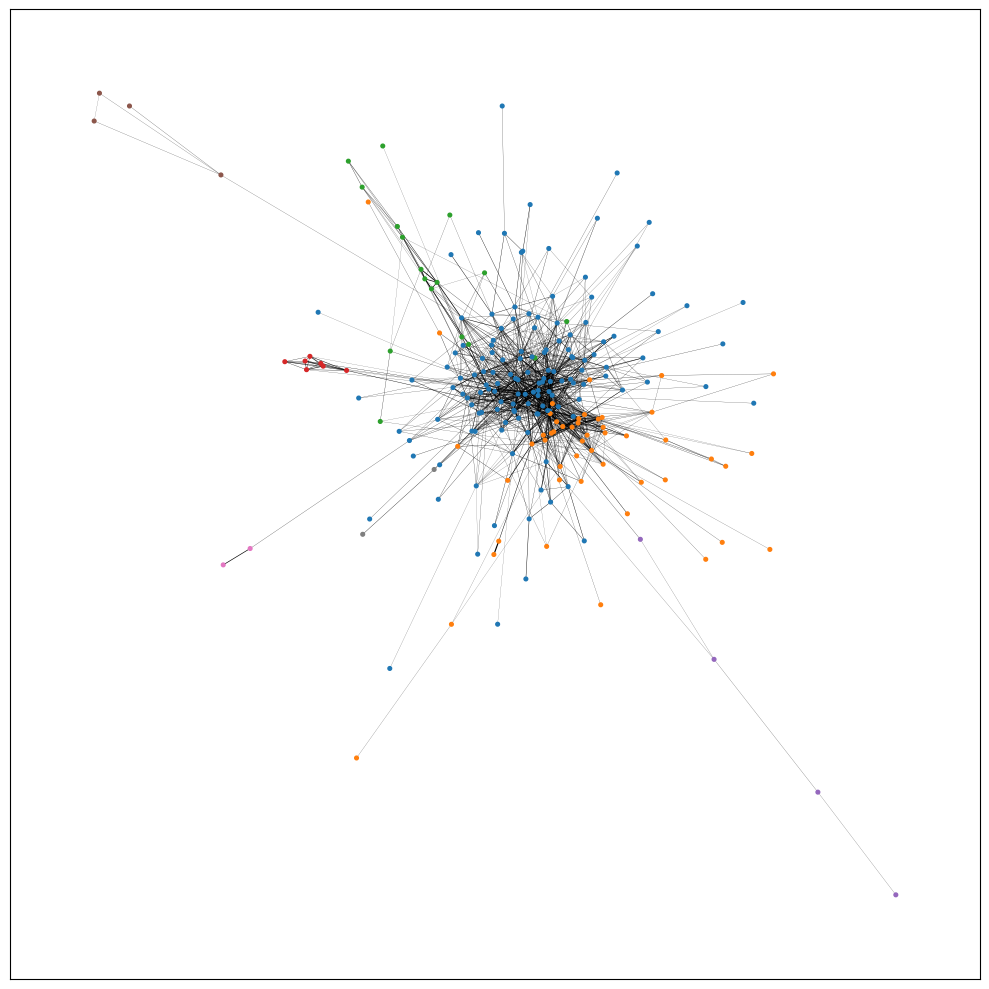

In [31]:
# resolution If resolution is less than 1, modularity favors larger communities. Greater than 1 favors smaller communities.
communities = nx.community.greedy_modularity_communities(G, resolution=0.7)

node_groups = []
for com in communities:
    node_groups.append(list(com)) 
print(len(node_groups))

palette = sns.color_palette(palette=None, n_colors=len(node_groups))

color_map = []
for node in G:
    for gr in node_groups:
        if node in gr:
            idx = node_groups.index(gr)
            color_map.append(palette[idx])
    
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, Gpos, node_color=color_map, with_labels=False, node_size=7, width=edge_weights, alpha=1)
plt.tight_layout()
plt.savefig(path.join(output_folder, 'communities-greedy_mod.png'))
plt.show()

In [32]:
# Save the user IDs for the largest communities 
with open(path.join(data_folder, 'users.pickle'), 'rb') as f:
    users = pickle.load(f)

node_groups = sorted(node_groups, key=lambda x: -len(x))

gr_idx = 0
for gr in node_groups:
    gr_idx += 1
    if 10 < len(gr):        
        mask = users.index.isin(gr)    
        ids = users[mask]['random_id'].tolist()
        print('Group', gr_idx, ids)
        grids = pd.DataFrame(ids, columns=['User ID'])
        grids.to_csv(path.join(data_folder, f'group-{gr_idx}-nodes.csv'), index=False)

Group 1 [953, 956, 958, 961, 963, 964, 967, 973, 974, 977, 983, 988, 992, 993, 995, 1001, 1002, 1003, 1004, 1006, 1008, 1009, 1010, 1011, 1013, 1014, 1015, 1016, 1017, 1018, 1021, 1023, 1024, 1026, 1027, 1028, 1029, 1031, 1033, 1039, 1040, 1042, 1043, 1044, 1049, 1051, 1052, 1053, 1056, 1064, 1067, 1069, 1070, 1072, 1073, 1074, 1077, 1079, 1081, 1082, 1086, 1087, 1088, 1089, 1091, 1093, 1097, 1101, 1109, 1110, 1111, 1117, 1134, 1135, 1136, 1137, 1138, 1155, 1157, 1158, 1162, 1163, 1168, 1169, 1174, 1175, 1191, 1195, 1205, 1206, 1215, 1220, 1226, 1229, 1230, 1236, 1252, 1254, 1255, 1256, 1261, 1273, 1278, 1281, 1282, 1283, 1284, 1285, 1304, 1305, 1317, 1319, 1322, 1323, 1334, 1340, 1343, 1344, 1347, 1349, 1354, 1355, 1356, 1359, 1379, 1381, 1383, 1392, 1395, 1401, 1403, 1407, 1408, 1426, 1428, 1430, 1436, 1449, 1451]
Group 2 [959, 980, 981, 982, 984, 985, 991, 1005, 1025, 1030, 1035, 1041, 1048, 1058, 1065, 1066, 1071, 1098, 1102, 1113, 1118, 1120, 1131, 1140, 1141, 1142, 1188, 1216, 12

11


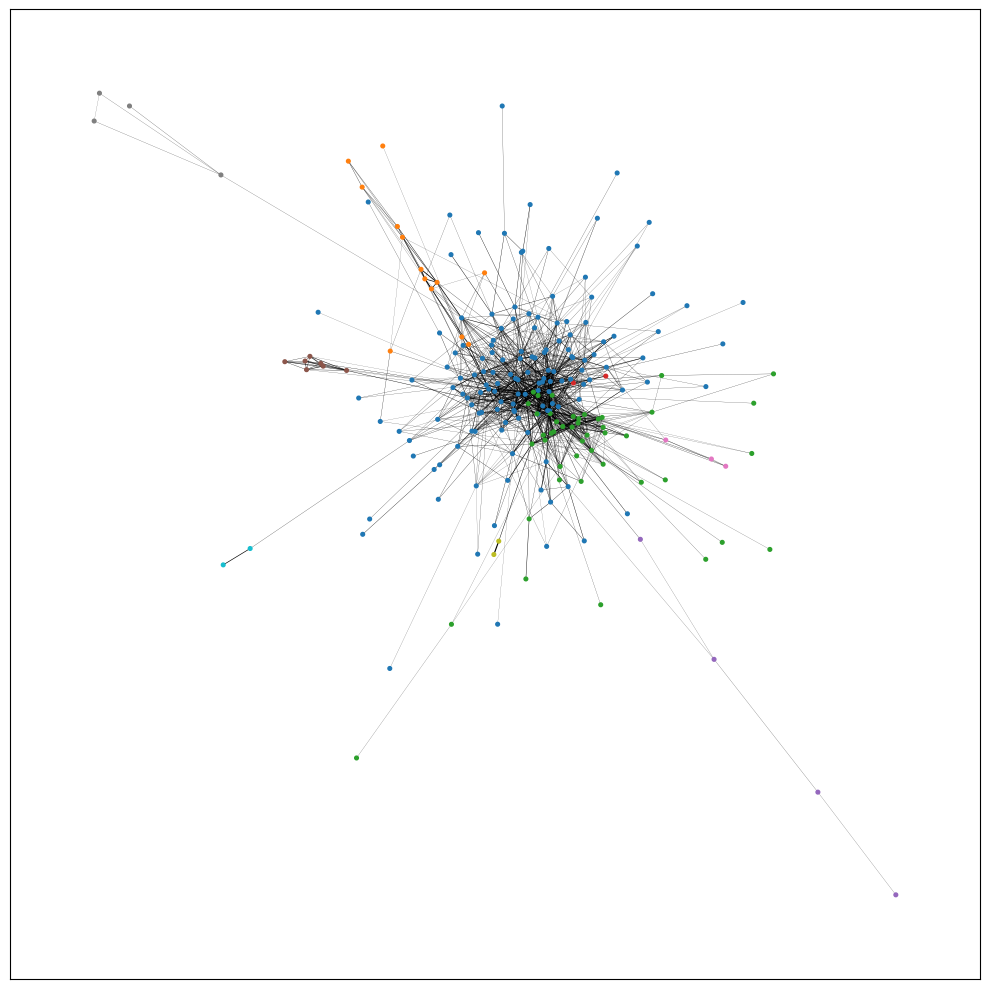

In [33]:
communities = nx.community.asyn_lpa_communities(G)

node_groups = []
for com in communities:
    node_groups.append(list(com)) 
print(len(node_groups))

palette = sns.color_palette(palette=None, n_colors=len(node_groups))

color_map = []
for node in G:
    for gr in node_groups:
        if node in gr:
            idx = node_groups.index(gr)
            color_map.append(palette[idx])
        
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, Gpos, node_color=color_map, with_labels=False, node_size=7, width=edge_weights, alpha=1)
plt.tight_layout()
plt.savefig(path.join(output_folder, 'communities-asyn_lpa.png'))
plt.show()

## Degree distribution

The distribution of the degrees of the nodes in a network is another basic property. The [degree of a node](https://en.wikipedia.org/wiki/Degree_(graph_theory)) is simply how many edges it has with other nodes. It measures the level of connectivity of each node. In the next cell, we calculate the histogram of the node degree, so that in each bin we have how many nodes in the network have a degree within that bin:

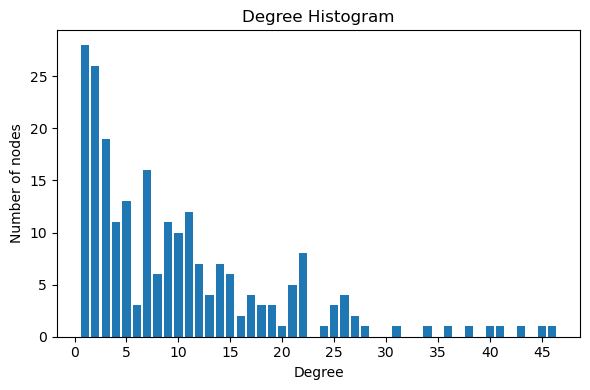

In [34]:
# Calculate degree distribution
degrees = [degree for node, degree in G.degree()]
degree_distribution = {}
for degree in degrees:
    if degree in degree_distribution:
        degree_distribution[degree] += 1
    else:
        degree_distribution[degree] = 1

# Plot the degree histogram
plt.figure(figsize=(6, 4))
plt.bar(degree_distribution.keys(), degree_distribution.values())

plt.title("Degree Histogram")
plt.ylabel("Number of nodes")
plt.xlabel("Degree")
plt.xticks(range(0, np.max(degrees), 5))
plt.tight_layout()
plt.savefig(path.join(output_folder, 'degree_hist.png'))
plt.show()

Examination of this plot suggests a power law for the [distribution of the node degree](https://en.wikipedia.org/wiki/Degree_distribution), which indicates that the contact network of participants of the OO simulation at WKU is [scale-free](https://en.wikipedia.org/wiki/Scale-free_network). Scale-free networks do  not have an "epidemic threshold" ([paper showing](https://arxiv.org/abs/cond-mat/0010317) this result), which means that no matter how much the contact rate between individuals is reduced, an epidemic will still take place:

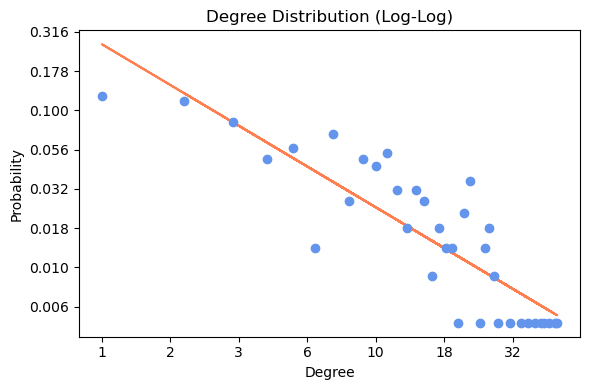

In [35]:
from matplotlib.ticker import FuncFormatter

x = np.log10(np.array(list(degree_distribution.keys())))
y = np.log10(np.array(list(degree_distribution.values())) / G.number_of_nodes())

# Perform linear regression and reate regression line
slope, intercept = np.polyfit(x, y, 1)
yreg = slope * x + intercept

def power_formatter_y(y, pos):
    return f'{10 ** y:.3f}'

def power_formatter_x(x, pos):
    return f'{round(10 ** x)}'

plt.figure(figsize=(6, 4))
plt.plot(x, yreg, color='coral', zorder=1)
plt.scatter(x, y, color='cornflowerblue', zorder=2)
plt.title("Degree Distribution (Log-Log)")
plt.ylabel("Probability")
plt.xlabel("Degree")
plt.gca().yaxis.set_major_formatter(FuncFormatter(power_formatter_y))
plt.gca().xaxis.set_major_formatter(FuncFormatter(power_formatter_x))
plt.tight_layout()
plt.savefig(path.join(output_folder, 'degree_dist_loglog.png'))
plt.show()

## Measures of node centrality

[These measures](https://en.wikipedia.org/wiki/Centrality) assign a number of ranking to nodes within a network corresponding to their network position or "importance" according to various criteria.

Below we calculate the [in-between](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html) and [eigenvector](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html) centralities, their distributions over the entire network, and then color the nodes by these centrality measures.

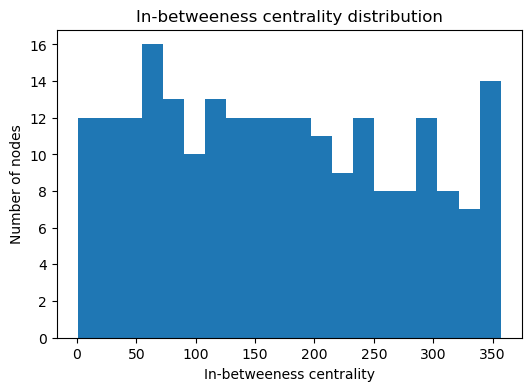

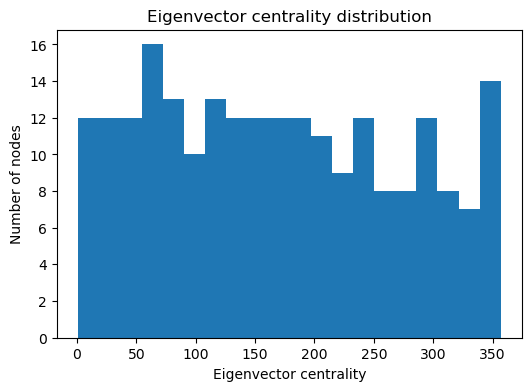

In [36]:
betweenness_centrality = list(nx.betweenness_centrality(G)) # Run betweenness centrality
eigenvector_centrality = list(nx.eigenvector_centrality(G)) # Run eigenvector centrality
plot_hist_values(betweenness_centrality, 'In-betweeness centrality', 'Number of nodes', 'In-betweeness centrality distribution')
plot_hist_values(eigenvector_centrality, 'Eigenvector centrality', 'Number of nodes', 'Eigenvector centrality distribution')

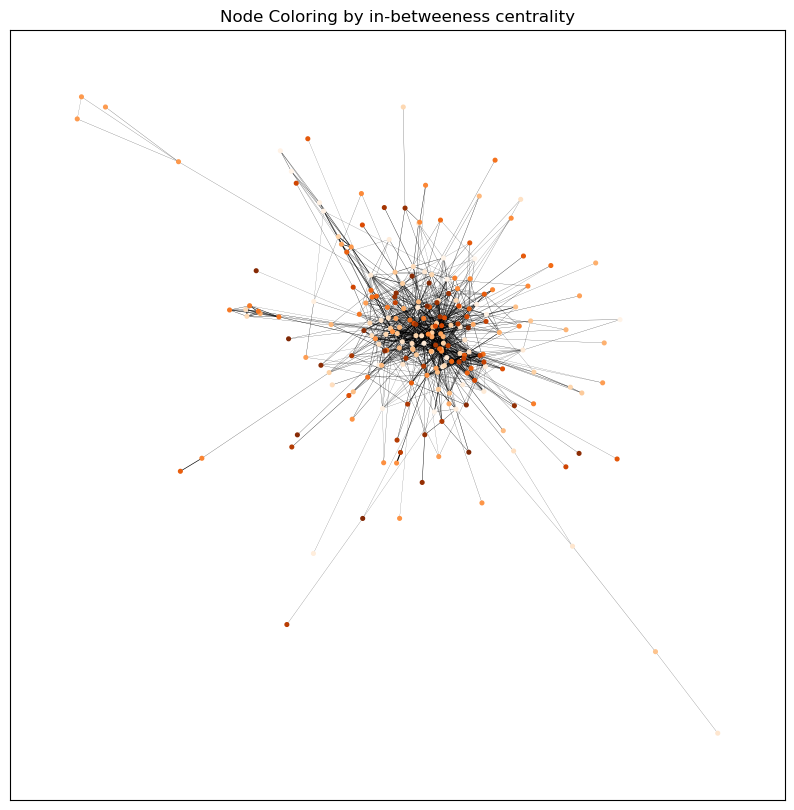

In [37]:
color_graph_by_attribute(G, Gpos, betweenness_centrality, 'Node Coloring by in-betweeness centrality', edge_weights)

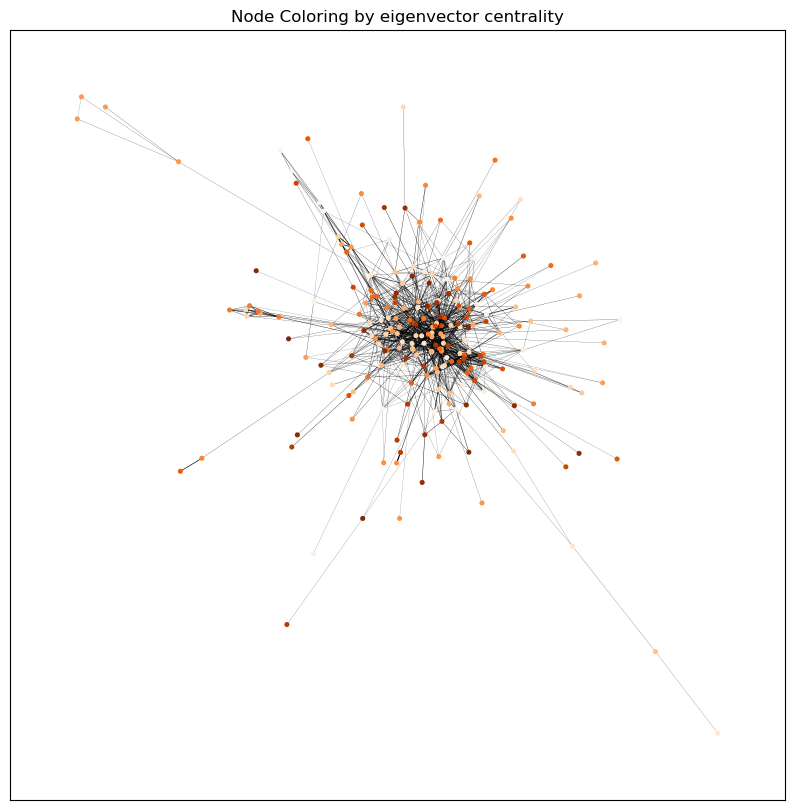

In [38]:
color_graph_by_attribute(G, Gpos, eigenvector_centrality, 'Node Coloring by eigenvector centrality', edge_weights)

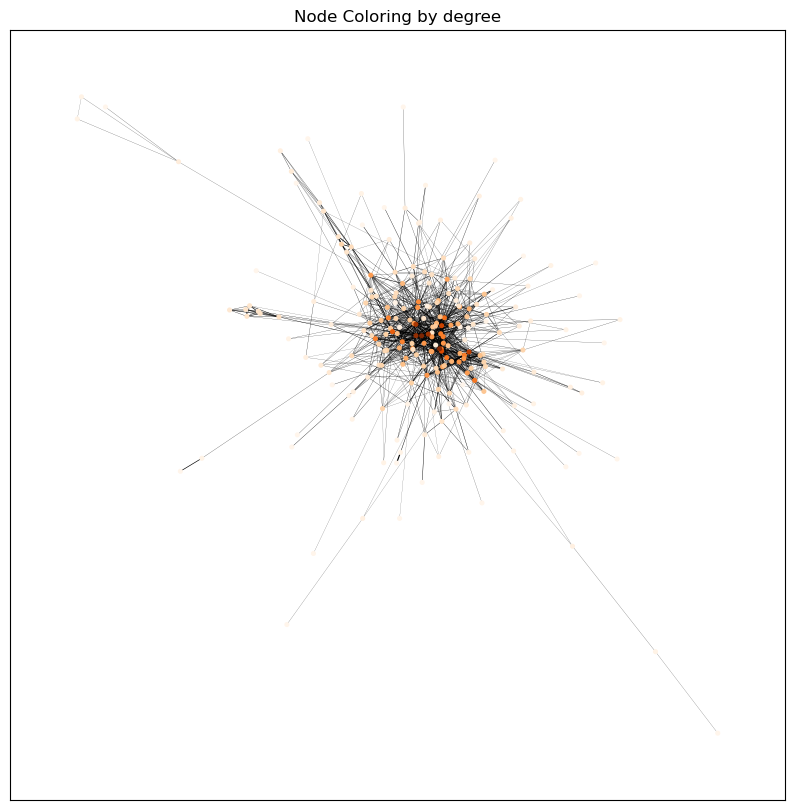

In [39]:
color_graph_by_attribute(G, Gpos, degrees, 'Node Coloring by degree', edge_weights)

## Animation of network spread on network

Using the daily node state data generated in the parsing notebook, we can color the nodes of the network according to their states over time to visualize the spread of the outbreak:

In [40]:
# Load the network states from file

with open(path.join(data_folder, 'all-network-states.pickle'), 'rb') as f:
    all_state = pickle.load(f)

num_frames = len(all_state)

Generating and saving animation (frames=297)...
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 

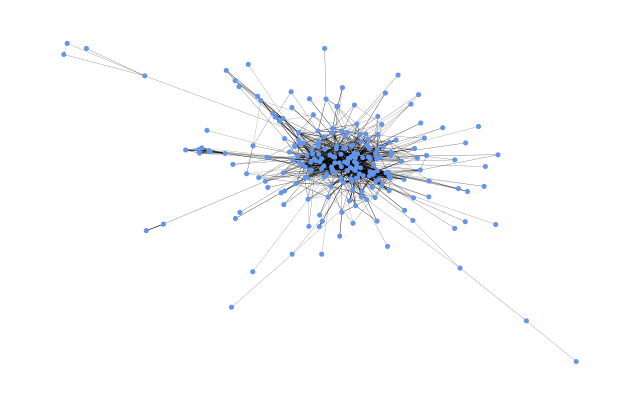

In [41]:
# Coded state:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
state_color = {0: clr.to_hex("cornflowerblue"),  # Susceptible
               1: clr.to_hex("darkorange"),      # Infected (index case)
               2: clr.to_hex("darkorange"),      # Infected (from someone else)
               3: clr.to_hex("darkgrey"),        # Dead 
               4: clr.to_hex("mediumseagreen"),  # Recovered 
               5: clr.to_hex("darkorchid")       # Vaccinated 
               } 

# Function to update the colors during the sim
def update_colors(frame):
    colors = [state_color[s] for s in all_state[frame]]
    print(frame, end=' ')
    
    # Redraw the graph with updated colors
    ax.clear() # Clear the previous drawing
    nx.draw(G, Gpos, ax=ax, node_color=colors, with_labels=False, node_size=7, width=edge_weights, alpha=1)
    
# Setup plot
fig, ax = plt.subplots(figsize=(8, 5))
nx.draw(G, Gpos, ax=ax, node_color=state_color[0], with_labels=False, node_size=7, width=edge_weights, alpha=1)

# Create animation
print(f'Generating and saving animation (frames={num_frames})...')
ani = FuncAnimation(fig, update_colors, frames=num_frames, interval=33)

# Save as mp4 file
ani.save(path.join(output_folder, 'graph_animation.mp4'), writer='ffmpeg')
print('\nDone')